In [1]:
import pickle
import os
from pathlib import Path
import pandas as pd
import sqlite3
import seaborn as sns

In [2]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

In [ ]:
import pandas as pd
import plotly.express as px
from typing import Union, Callable

def plot_time_evolution(
    df: pd.DataFrame,
    year_col: str,
    month_col: str,
    value_col: str,
    freq: str = "monthly",               # "monthly" or "yearly"
    agg: Union[str, Callable] = "sum",    # e.g. "sum","mean","median","max","min" or a callable
    title: str = None
):
    """
    Plot the evolution of `value_col` over time using (year, month) columns.

    - If `freq="monthly"`: aggregates by year+month then plots monthly values.
    - If `freq="yearly"` : aggregates by year+month first, then aggregates those
      monthly values into yearly values using the same `agg`.

    Parameters
    ----------
    df : DataFrame containing at least [year_col, month_col, value_col]
    year_col, month_col : column names for year and month (month as 1–12)
    value_col : name of the variable to plot
    freq : "monthly" | "yearly"
    agg : aggregation function name or callable (sum/mean/median/max/min/…)
    title : optional plot title

    Returns
    -------
    plotly.graph_objects.Figure
    """
    if freq not in {"monthly", "yearly"}:
        raise ValueError("freq must be 'monthly' or 'yearly'")

    # Ensure integers for year/month and build a first-of-month timestamp
    tmp = df[[year_col, month_col, value_col]].copy()
    tmp[year_col] = tmp[year_col].astype(int)
    tmp[month_col] = tmp[month_col].astype(int)
    tmp["date"] = pd.to_datetime(
        {"year": tmp[year_col], "month": tmp[month_col], "day": 1},
        errors="coerce"
    )

    # 1) Aggregate to monthly (handles duplicates per month safely)
    monthly = (
        tmp.groupby("date", as_index=False)
           .agg(**{value_col: (value_col, agg)})
           .sort_values("date")
    )

    if freq == "monthly":
        fig = px.line(
            monthly, x="date", y=value_col, markers=True,
            title=title or f"{value_col} — monthly ({agg})"
        )
        fig.update_layout(xaxis_title="Month", yaxis_title=value_col)
        return fig

    # 2) Aggregate monthly -> yearly
    yearly = (
        monthly.assign(year=monthly["date"].dt.year)
               .groupby("year", as_index=False)
               .agg(**{value_col: (value_col, agg)})
               .sort_values("year")
    )
    fig = px.line(
        yearly, x="year", y=value_col, markers=True,
        title=title or f"{value_col} — yearly ({agg} of monthly)"
    )
    fig.update_layout(xaxis_title="Year", yaxis_title=value_col)
    return fig


In [5]:
import pickle

# Replace with your actual file path
file_path = PROJECT_ROOT / "outputs_srm/all_results_Casablanca-Settat_consommation_kwh_gr.pkl"

# Open the pickle file in binary read mode
with open(file_path, "rb") as file:
    data = pickle.load(file)



In [14]:
for el in data[0]["best_model"]["pred_monthly_matrix"]:
    print(el.sum())

1129295116.1654725
1129531884.9130454
1128620546.7117
1128620546.6562543
1129982030.1839204
1129533810.1568573
1128620546.6877244
1128620546.6692195
1128620546.6877239
1128620546.6682265
1031441541.6364876
1121280038.3555932
1121280038.3555932
1121280038.3555934


In [4]:
db_conn = sqlite3.connect(PROJECT_ROOT / "data/ONEE_Distributeurs_consumption.db")

In [5]:
query_dist = f"""
    SELECT
        year as annee,
        month as mois,
        distributeur,
        SUM(consumption_value) as consommation_kwh
    FROM consumption
    WHERE region = 'Casablanca-Settat'
    GROUP BY year, month, distributeur
    ORDER BY year, month, distributeur
"""


In [19]:
df = pd.read_sql_query(query_dist, db_conn)

In [18]:
df["distributeur"].unique()

array(['LYDEC CASABLANCA', 'RADEEJ EL JADIDA'], dtype=object)

In [20]:
temp = df[df["distributeur"] == "RADEEJ EL JADIDA"]
temp = temp.groupby("annee", as_index = False)["consommation_kwh"].sum()

<Axes: xlabel='annee', ylabel='consommation_kwh'>

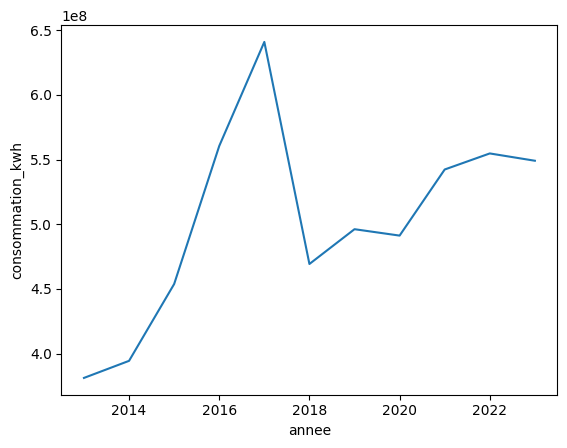

In [21]:
sns.lineplot(x=temp["annee"], y = temp["consommation_kwh"])

# 03/11/2025

In [40]:
df = pd.read_csv(PROJECT_ROOT / "data/cd_data_2013_2023.csv")

In [41]:
df_all = df.groupby(['annee', 'mois']).agg({
            "consommation": 'sum',
            'temperature': 'mean'
        }).reset_index()

In [42]:
df["activite"].unique()

array(['METALLURGIE',
       "FABRICATION D'AUTRES PRODUITS MINERAUX NON METALLIQUES",
       'TRANSPORTS TERESSTRES',
       "PRODUCTION ET DISTTRIBUTION D'ELECTRICITE, DE GAZ ET DE CHALEUR",
       'ADMINISTRATION PUBLIQUE', 'INDUSTRIE DU PAPIER ET DU CARTON',
       "CAPTAGE, TRAITEMENT ET DISTRIBUTION D'EAU",
       'AGRICULTURE, CHASSE, SERVICES ANNEXES',
       'EXTRACTION, EXPLOITATION ET ENRICHISSEMENT DE MINERAIS METTALLIQUES',
       'AUTRES INDUSTRIES EXTRACTIVES',
       'SERVIVES AUXILIAIRES DES TRANSPORTS', 'INDUSTRIE CHIMIQUE',
       "FABRICATION D'EQUIPEMENTS DE RADIO, TELEVISION ET COMMUNICATION",
       'COKEFACTION, RAFFINAGE, INDUSTRIE NUCLEAIRE', 'INDUSTRIE TEXTILE',
       'TRAVAIL DES METAUX', 'INDUSTRIE AUTOMOBILE',
       'BATIMENT ET TRAVAUX PUBLICS', 'industries alimentaires'],
      dtype=object)

In [ ]:
df_activite = df[df["activite"] == "ADMINISTRATION PUBLIQUE"]
df_activite = df_activite.groupby(['annee', 'mois']).agg({
            "consommation": 'sum',
            'temperature': 'mean'
        }).reset_index()

In [59]:
df_activite["partenaire"].unique()

array(['FORCES ARMEES ROYALES'], dtype=object)

In [ ]:
plot_time_evolution(df_activite, "annee", "mois", "consommation")

In [48]:
plot_time_evolution(df_activite, "annee", "mois", "consommation", freq = "yearly", agg = "sum")

In [60]:
# pip install pandas matplotlib numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from typing import Union, Callable, Optional

def export_activity_evolution_to_pdf(
    df: pd.DataFrame,
    pdf_path: str,
    activity_col: str = "activite",
    year_col: str = "annee",
    month_col: str = "mois",
    value_col: str = "consommation",
    client_col: str = "partenaire",
    contract_col: str = "contrat",
    agg: Union[str, Callable] = "sum",
    title_slides: bool = True,
    figsize=(13.5, 7.6),          # ⬅️ bigger default; pass your own to change
    title_prefix: str = "Activité",
    font_main: int = 16,
):
    """
    For each activity:
      - Title slide with activity name + (#unique clients, #unique contracts)
      - Monthly evolution (annual totals annotated, kept inside axes)
      - Yearly evolution (annotated)

    Tip: Pass a custom `figsize` (e.g., (14, 8)) if you want even bigger slides.
    """
    if df.empty:
        raise ValueError("Input dataframe is empty.")

    data = df.copy()
    data[year_col]  = pd.to_numeric(data[year_col],  errors="coerce").astype("Int64")
    data[month_col] = pd.to_numeric(data[month_col], errors="coerce").astype("Int64")
    data = data.dropna(subset=[activity_col, year_col, month_col, value_col])

    def fmt_num(v: float) -> str:
        try:
            return f"{v:,.0f}".replace(",", " ")
        except Exception:
            return str(v)

    with PdfPages(pdf_path) as pdf:
        for act in pd.Index(sorted(data[activity_col].dropna().unique())):
            raw_act = data.loc[data[activity_col] == act].copy()
            if raw_act.empty:
                continue

            n_clients  = (raw_act[client_col].nunique(dropna=True)
                          if client_col in raw_act.columns else None)
            n_contract = (raw_act[contract_col].nunique(dropna=True)
                          if contract_col in raw_act.columns else None)

            monthly = (
                raw_act[[year_col, month_col, value_col]]
                .groupby([year_col, month_col], as_index=False)
                .agg(**{value_col: (value_col, agg)})
                .sort_values([year_col, month_col])
            )
            monthly["date"] = pd.to_datetime(
                dict(year=monthly[year_col].astype(int),
                     month=monthly[month_col].astype(int),
                     day=1),
                errors="coerce"
            )
            monthly = monthly.dropna(subset=["date"])

            yearly = (
                monthly.assign(year=lambda d: d["date"].dt.year)
                       .groupby("year", as_index=False)
                       .agg(**{value_col: (value_col, agg)})
                       .sort_values("year")
            )

            # ---- Title slide
            if title_slides:
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111)
                ax.axis("off")
                ax.text(0.5, 0.62, f"{title_prefix}: {act}",
                        ha="center", va="center",
                        fontsize=28, fontweight="bold")
                lines = []
                if n_clients  is not None: lines.append(f"Clients uniques : {n_clients}")
                if n_contract is not None: lines.append(f"Contrats uniques : {n_contract}")
                if lines:
                    ax.text(0.5, 0.45, "\n".join(lines),
                            ha="center", va="center", fontsize=font_main)
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

            # ---- Monthly (with safe annual annotations)
            if not monthly.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.plot(monthly["date"], monthly[value_col], marker="o")
                ax.set_title(f"{act} — {value_col} (mensuel)", fontsize=font_main)
                ax.set_xlabel("Mois")
                ax.set_ylabel(value_col)
                ax.grid(True, alpha=0.25)

                # pad the top a bit so annotations fit
                ymax = float(np.nanmax(monthly[value_col].to_numpy()))
                if np.isfinite(ymax) and ymax > 0:
                    ax.set_ylim(top=ymax * 1.15)

                if not yearly.empty:
                    # get last month in each year to place labels
                    last_pts = (
                        monthly.assign(year=monthly["date"].dt.year)
                               .sort_values("date")
                               .groupby("year", as_index=False)
                               .tail(1)[["date", value_col]]
                    ).rename(columns={value_col: "last_month_value"})
                    ann = (last_pts.assign(year=last_pts["date"].dt.year)
                                 .merge(yearly, on="year", how="left"))

                    # smart y position: keep text inside axis (near top or just above the last monthly point)
                    y_top = ax.get_ylim()[1]
                    pad   = 0.05 * ymax if np.isfinite(ymax) else 0
                    for _, r in ann.iterrows():
                        # preferred position just above last monthly point
                        y_pref = float(r.get("last_month_value", np.nan)) + pad
                        # clamp near the top if that would go out of range
                        y_plot = min(y_pref, y_top * 0.96)
                        ax.annotate(
                            fmt_num(r[value_col]),  # annual total text
                            xy=(r["date"], y_plot),
                            xytext=(0, 0),
                            textcoords="offset points",
                            ha="center", va="bottom", fontsize=12
                        )

                fig.tight_layout()
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

            # ---- Yearly (annotate each year)
            if not yearly.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.plot(yearly["year"], yearly[value_col], marker="o")
                ax.set_title(f"{act} — {value_col} (annuel)", fontsize=font_main)
                ax.set_xlabel("Année")
                ax.set_ylabel(value_col)
                ax.grid(True, alpha=0.25)

                # give a little headroom for labels
                y2max = float(np.nanmax(yearly[value_col].to_numpy()))
                if np.isfinite(y2max) and y2max > 0:
                    ax.set_ylim(top=y2max * 1.10)

                for _, r in yearly.iterrows():
                    ax.annotate(fmt_num(r[value_col]),
                                xy=(r["year"], r[value_col]),
                                xytext=(0, 10),
                                textcoords="offset points",
                                ha="center", va="bottom", fontsize=12)

                fig.tight_layout()
                pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

    print(f"Saved PDF to {pdf_path}")


In [61]:
# Instead of per-activity manual plotting, just call on the *raw* df:
export_activity_evolution_to_pdf(
    df,                           # raw dataframe with all activities
    pdf_path="activites_evolution.pdf",
    activity_col="activite",
    year_col="annee",
    month_col="mois",
    value_col="consommation",
    client_col="partenaire",
    contract_col="contrat",
    agg="sum",
    title_slides=True
)

Saved PDF to activites_evolution.pdf


### pickles

In [38]:
import pickle

# Open the file in binary read mode
with open(PROJECT_ROOT / r"outputs_cd\all_results_partenaires_s4.pkl", "rb") as f:
    data = pickle.load(f)
